# RW Fit

Here we fit the RW model to determine the learning rates for each simulated participant

In [66]:
import sys
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.gridspec as gs

import seaborn as sns

sys.path.append('../../rw_models')
sys.path.append('rw_models')

from rw_optim import predict_exp

base_path = '/u/jschubert/learning_bias/humans/optimism/data/'
orig = pd.read_csv(f'{base_path}exp1.csv')
df_sim = orig
df_sim

,Unnamed: 0,participant_idx,trials_idx,cues,actions,rewards
0,0,0,0,2.0,0.0,0.0
1,1,0,1,3.0,1.0,0.5
2,2,0,2,3.0,1.0,0.5
3,3,0,3,2.0,0.0,0.0
4,4,0,4,0.0,1.0,0.0
...,...,...,...,...,...,...
4795,4795,49,91,0.0,0.0,0.0
4796,4796,49,92,0.0,0.0,0.0
4797,4797,49,93,1.0,0.0,0.5
4798,4798,49,94,3.0,1.0,0.5


<Axes: xlabel='trial_cue', ylabel='regret'>

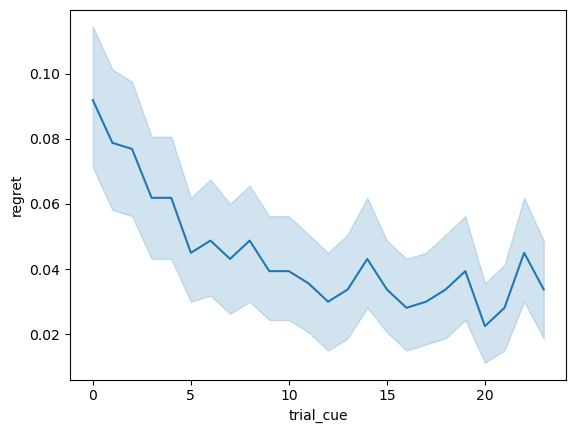

In [67]:

# Set initial regret to 0
df_sim['regret'] = 0

# Update regret based on specific conditions
df_sim['regret'] = np.where((df_sim['cues'] == 1) & (df_sim['actions'] == 1), 0.375, df_sim['regret'])
df_sim['regret'] = np.where((df_sim['cues'] == 2) & (df_sim['actions'] == 0), 0.375, df_sim['regret'])

# Count trials for each casino separately from 0 to 23
df_sim['trial_cue'] = df_sim.groupby(['participant_idx', 'cues']).cumcount()

# Swap values 1 and 2 in the 'cues' column
# this is because cue 1 and cue 2 have been switched in all other analyses
df_sim['cues'] = df_sim['cues'].replace({1: 2, 2: 1})

sns.lineplot(data=df_sim, x='trial_cue', y='regret', errorbar=('ci', 95))

/tmp/ipykernel_18127/906756682.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=('ci', 95)` for the same effect.

  sns.lineplot(data=df, x='trial_cue', y='regret', ax=ax1, color='#332288', ci=95)


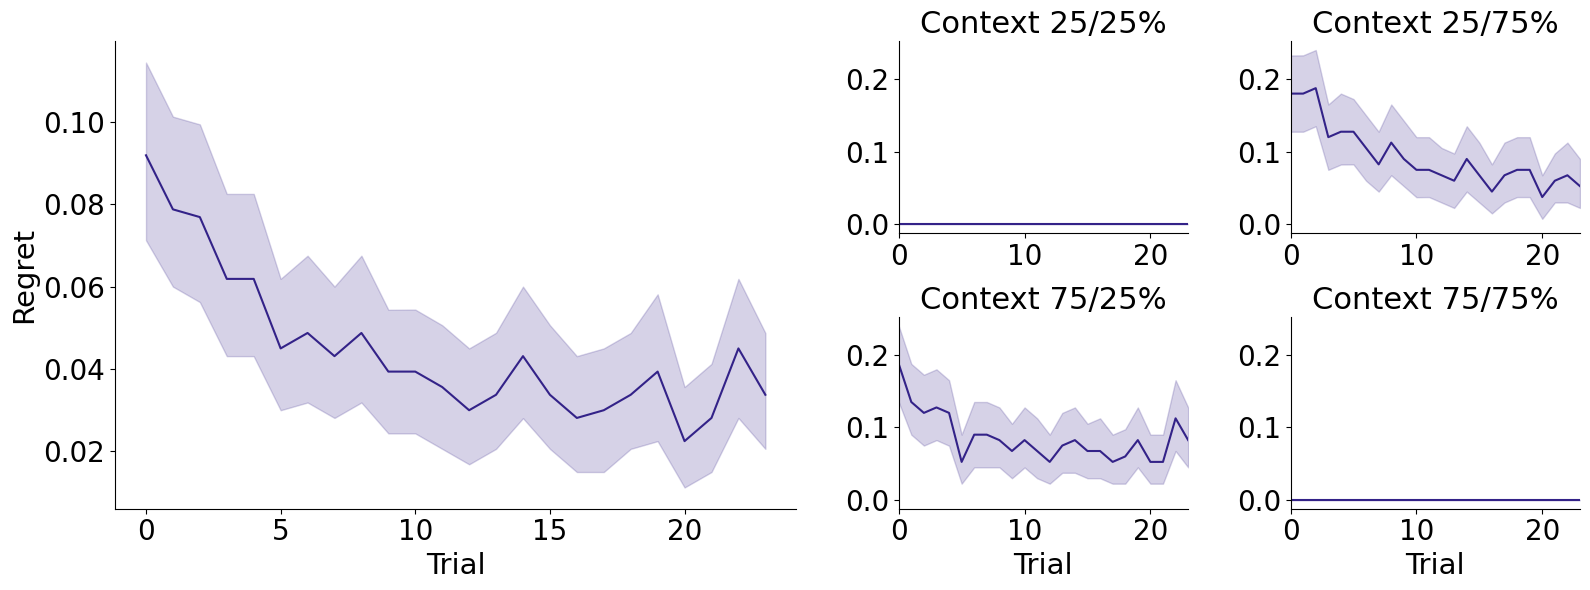

In [71]:
fig = plt.figure(figsize=(16,6), dpi=100)

# Setting up grid and positions for subplots
grid = gs.GridSpec(2, 4, figure=fig)
ax1 = fig.add_subplot(grid[0:2, 0:2])

# Plots on the right half
ax2 = fig.add_subplot(grid[0, 2])
ax3 = fig.add_subplot(grid[0, 3], sharey=ax2)
ax4 = fig.add_subplot(grid[1, 2], sharey=ax2)
ax5 = fig.add_subplot(grid[1, 3], sharey=ax2)

axs = [ax2, ax3, ax4, ax5]
title = ['Context 25/25%', 'Context 25/75%', 'Context 75/25%', 'Context 75/75%']

# Main plot
df = df_sim
sns.lineplot(data=df, x='trial_cue', y='regret', ax=ax1, color='#332288', ci=95)
ax1.tick_params(labelsize=20)
#ax1.set_title('Test set performance', fontsize=18)
ax1.set_xlabel('Trial', fontsize=21)
ax1.set_ylabel('Regret', fontsize=21)

# Smaller plots
for i, ax in enumerate(axs):
    df_temp = df[df['cues'] == i]
    ax.grid(False)
    sns.lineplot(data=df_temp, x='trial_cue', y='regret', ax=ax, color='#332288')  
    sns.despine()
    ax.set_title(title[i], fontsize=22)
    ax.tick_params(labelsize=20)
    if i == 1 or i == 0:
        ax.set_xlabel('', fontsize=21)
    else:
        ax.set_xlabel('Trial', fontsize=21)
    ax.set_ylabel(' ', fontsize=21)
    ax.set_xlim(0,23)


plt.tight_layout()
plt.show()

Fit RW Model

In [12]:
model_name = 'humans'

q_inital = np.asarray([[.25,.25],[.25,.25],[.25,.25],[.25,.25]])
random_alpha_range = (0,1) # samples uniformly in between this range as an inital guess for alpha
random_beta_range = (0,5) # and for beta respectively.
optim_bounds = ([0,1],[0, np.inf]) #alpha, beta | bounds during optimization
n_optim_inits = 10 # how often the optimization procedure is repeated

actions = df_sim.pivot(index='participant_idx',columns='trials_idx',values='actions').values.astype(int)
rewards = df_sim.pivot(index='participant_idx',columns='trials_idx',values='rewards').values
cues = df_sim.pivot(index='participant_idx',columns='trials_idx',values='cues').values.astype(int)

pipeline = predict_exp(random_alpha_range, random_beta_range, q_inital, n_optim_inits, optim_bounds, concatenated_trial=False)        
df = pipeline.fit(actions,rewards,cues,bounded=True)
df['bic_dif'] = df['c_bic'] - df['pm_bic']
df['is_pm'] = df['bic_dif'] >= 0
df['c_1/b'] = 1 / df['c_b']
df['pm_1/b'] = 1 / df['pm_b']
df.to_csv(base_path+"/rw_fit_of_participant.csv", index=False, mode='w')

Plot Average

In [24]:
df = pd.read_csv(base_path+"/rw_fit_of_participant.csv")
df.describe()[['pm_bic', 'c_bic', 'p_a', 'm_a', 'pm_b']].round(2)

,pm_bic,c_bic,p_a,m_a,pm_b
count,50.00,50.00,50.00,50.00,50.00
mean,93.67,99.55,0.33,0.17,482.69
std,32.99,31.73,0.35,0.30,901.63
min,27.85,38.62,0.00,0.00,1.26
25%,62.70,70.76,0.02,0.00,7.60
50%,96.10,102.09,0.22,0.03,12.69
75%,120.46,128.75,0.46,0.11,171.08
max,144.33,141.00,1.00,1.00,2863.31


Plot BIC

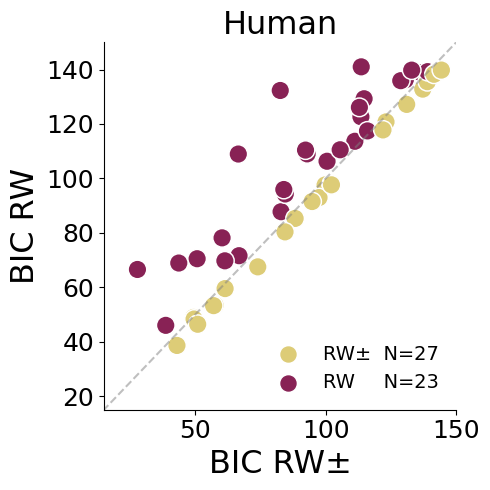

In [25]:
fig, axs = plt.subplots(1,1, dpi=100, figsize=(5,5), sharey=True)
title= ['Human']

for i in range(1):   
    ax = axs
    plt_df = df
    sns.scatterplot( x=plt_df[('pm_bic')], y=plt_df[('c_bic')], hue=plt_df['is_pm'], ax=ax, palette=['#DDCC77', '#882255'], s=180)
    sns.despine(ax=ax)
    ax.plot([0,150],[0,150],linestyle='dashed',color='grey',alpha=.5)
    ax.set_xlim((15,150))
    ax.set_ylim((15,150))
    ax.set_ylabel('BIC RW', fontsize=23)
    ax.set_xlabel('BIC RW±', fontsize=23)
    ax.tick_params(labelsize=18)
    rwpm = str(np.sum(plt_df.is_pm))
    nrwpm = str(np.sum(~plt_df.is_pm))

    ax.set_title(title[i], fontsize=23)

    # replace legend with text "Subjects" False = RW, True = RW±
    handles, labels = ax.get_legend_handles_labels()
    order=[1,0]
    ax.legend(handles= handles, labels=[f'RW± N='+rwpm, 'RW   N='+nrwpm], loc='lower right', frameon=False, fontsize=14, markerscale=1.8)

#plt.suptitle('Model comparison of RW and RW± in terms of BIC', fontsize=20)
plt.tight_layout()
plt.show()

fig.tight_layout()
#fig.savefig('bic.png', format='png', bbox_inches='tight')

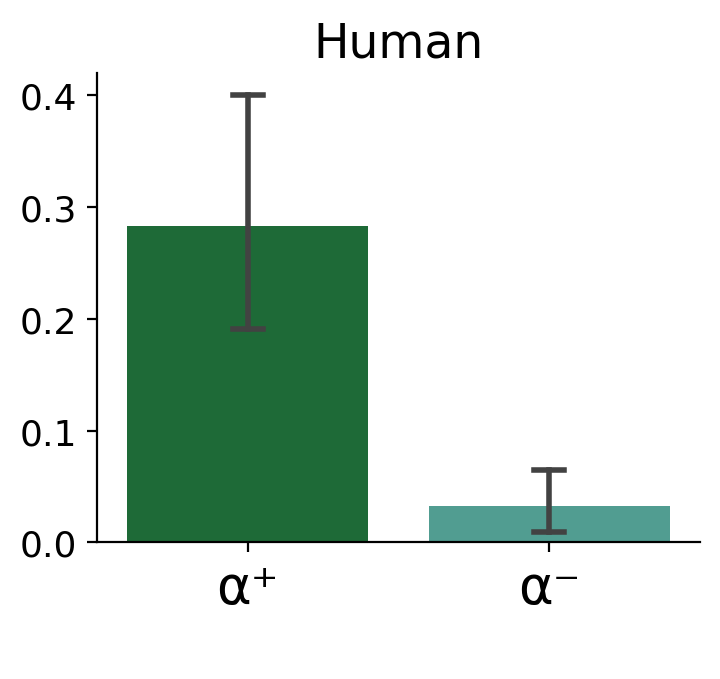

In [26]:
fig, axs = plt.subplots(1,1, figsize=(3.7,3.5), dpi=200, sharey=True)

title= ['Human']

for i in range(1):   
    ax = axs
    plt_df = df
    plt_df = plt_df[plt_df.is_pm == True]
    scatter_pm = plt_df[[('p_a'),('m_a')]]
    scatter_pm_melted = scatter_pm.melt()
    fig_args = {'x': 'variable',
                'y': 'value',
                'data': scatter_pm_melted,
                'capsize':0.1,
                'errwidth':2,
                'palette': ['#117733', '#44AA99']}
    pairs = [(('p_a', 'm_a'))]


    sns.barplot(ax=ax, **fig_args)
    sns.despine(ax=ax)
    ax.set_xticklabels(['α⁺','α⁻'], fontsize=19)
    ax.set_ylabel('')
    ax.set_xlabel(' ', fontsize=13)
    ax.tick_params(axis='y',labelsize=13)
    rwpm = np.sum(plt_df.is_pm)
    nrwpm = np.sum(~plt_df.is_pm)
    ax.set_title(title[i], fontsize=17)

    configuration = {'test': 't-test_ind',
                    'comparisons_correction':None,
                    'text_format':'star'}
    #annotator = Annotator(ax=ax, pairs=pairs, **fig_args, plot='barplot')
    #annotator.configure(**configuration).apply_test().annotate()
plt.tight_layout()
plt.show()
fig.tight_layout()
#fig.savefig('lr.pdf', format='pdf', bbox_inches='tight')